
# DR Comparison with Pandas Tables & Summary Dashboard

We evaluate **linear vs non-linear vs semi-linear** dimensionality reduction with **pandas DataFrames** for clear tabular reporting and a concise **summary dashboard**.

**Sections**
1. **Linear techniques on linear data** (10 common linear methods)
2. **Non-linear techniques on non-linear data** (5 common non-linear methods)
3. **Top-3 performers from Sections 1 & 2 on semi-linear data** (6 methods total)

**Metrics** (on centered data): Frobenius norm, Relative Frobenius, Spectral norm, MSE, Reconstruction $R^2$.


## Imports

In [1]:
import numpy as np
import pandas as pd
from numpy.linalg import norm, pinv
from scipy.linalg import svdvals
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.decomposition import (
    PCA, IncrementalPCA, TruncatedSVD, FactorAnalysis, # FastICA,
    SparsePCA, MiniBatchSparsePCA, DictionaryLearning, KernelPCA
)
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.datasets import make_swiss_roll

np.random.seed(42)

## Utilities

### Metrics

In [2]:
def frobenius_norm(R):
    return norm(R, 'fro')

def relative_frobenius(R, Xc):
    return frobenius_norm(R) / (norm(Xc, 'fro') + 1e-12)

def spectral_norm(R):
    return svdvals(R)[0]

def mse(R):
    return np.mean(R**2)

def reconstruction_R2(R, Xc):
    return 1.0 - (frobenius_norm(R)**2) / (norm(Xc, 'fro')**2 + 1e-12)

METRICS = ['Frobenius', 'RelFro', 'Spectral', 'MSE', 'R2']
TARGET_DIMS = [2, 4, 6, 8]


### Utilities for results

In [3]:
def results_to_df(results_dict):
    '''Convert nested results {dim: [rows...]} to a pandas DataFrame.
    Returns (df_scores, df_errors) where df_errors includes method/dim/error.'''
    rows_scores = []
    rows_errors = []
    for d, rows in results_dict.items():
        for r in rows:
            if 'Error' in r:
                rows_errors.append({'Method': r['Method'], 'Dim': d, 'Error': r['Error']})
            else:
                rows_scores.append({
                    'Method': r['Method'], 'Dim': d,
                    'Frobenius': r['Frobenius'], 'RelFro': r['RelFro'],
                    'Spectral': r['Spectral'], 'MSE': r['MSE'], 'R2': r['R2']
                })
    df_scores = pd.DataFrame(rows_scores)
    df_errors = pd.DataFrame(rows_errors)
    return df_scores, df_errors

def avg_metric_by_method(df_scores, metric='R2'):
    '''Compute average of a metric across dims per method.'''
    return df_scores.groupby('Method')[metric].mean().sort_values(ascending=False)



# Plot trends per metric using DataFrame

def plot_metric_trends_df(df_scores, title_prefix=""):
    if df_scores.empty:
        print("No successful results to plot.")
        return
    plt.style.use('seaborn-v0_8-whitegrid')
    FIGSIZE = (10, 6)
    for m in METRICS:
        fig, ax = plt.subplots(figsize=FIGSIZE)
        for meth, grp in df_scores.groupby('Method'):
            grp_sorted = grp.sort_values('Dim')
            ax.plot(grp_sorted['Dim'], grp_sorted[m], marker='o', linewidth=2, markersize=6, label=meth)
        ax.set_xlabel('Reduced dimension (k)', fontsize=12)
        ax.set_ylabel('Reconstruction $R^2$' if m == 'R2' else m, fontsize=12)
        ax.set_title(f"{title_prefix}{m} vs. dimensionality", fontsize=14)
        ax.grid(True, alpha=0.3)
        if m in ('Frobenius', 'Spectral', 'MSE'):
            ymin, ymax = ax.get_ylim()
            if ymin > 0 and ymax / max(ymin, 1e-12) > 10:
                ax.set_yscale('log')
        ax.legend(ncol=2, fontsize=9, frameon=True)
        fig.tight_layout()
        plt.show()


# Rankings as DataFrames

def rankings_df(df_scores):
    '''Return dict {dim: {metric: df_ranking}} with sorted DataFrames.'''
    rankings = {}
    for d, grp in df_scores.groupby('Dim'):
        rankings[d] = {}
        for m in METRICS:
            ascending = (m != 'R2')  # R2 higher is better; others lower is better
            df_rank = grp[['Method', m]].groupby('Method').mean().sort_values(by=m, ascending=ascending)
            df_rank = df_rank.reset_index()
            df_rank['Rank'] = np.arange(1, len(df_rank)+1)
            rankings[d][m] = df_rank[['Rank', 'Method', m]]
    return rankings


### Data generators

In [4]:

def generate_linear_data(n_samples=2000, n_features=12, true_dim=5):
    scales = np.array([3.0, 2.5, 2.0, 1.5, 1.0])
    S = np.random.randn(n_samples, true_dim) * scales
    n_mix = 9
    B = np.random.randn(true_dim, n_mix)
    Y = S @ B
    Y += 0.05 * np.random.randn(n_samples, n_mix)
    f10 = 0.6 * Y[:, 0] - 0.4 * Y[:, 3] + 0.1 * np.random.randn(n_samples)
    f11 = -0.2 * Y[:, 5] + 0.5 * Y[:, 1] + 0.1 * np.random.randn(n_samples)
    f12 = 0.5 * np.random.randn(n_samples)
    X = np.column_stack([Y, f10, f11, f12])
    X += 0.02 * np.random.randn(n_samples, X.shape[1])
    mu = X.mean(axis=0)
    Xc = X - mu
    return Xc, mu, S

def generate_nonlinear_data(n_samples=2000, n_features=12, true_dim=5):
    X_sr, t = make_swiss_roll(n_samples=n_samples, noise=0.05)
    z_sr = X_sr[:, 2]
    t = (t - t.mean()) / (t.std() + 1e-12)
    z_sr = (z_sr - z_sr.mean()) / (z_sr.std() + 1e-12)
    S_gauss = np.random.randn(n_samples, 3) * np.array([2.5, 1.5, 1.0])
    S = np.column_stack([t, z_sr, S_gauss])
    f = []
    f.append(np.sin(S[:,0]) + 0.3*S[:,2])
    f.append(np.cos(S[:,1]) + 0.5*S[:,3])
    f.append(S[:,0]*S[:,1] + 0.2*S[:,4])
    f.append(S[:,2]**2 - 0.1*S[:,3])
    f.append(np.tanh(0.5*S[:,0] + 0.3*S[:,2]))
    f.append(np.exp(0.05*S[:,1]) - 1.0)
    f.append(0.7*S[:,3]*np.sin(S[:,1]))
    f.append(0.6*np.cos(S[:,0]) + 0.2*S[:,4])
    f.append((S[:,2]+S[:,3])**2 * 0.05)
    f.append(0.4*S[:,0] - 0.3*S[:,1] + 0.1*np.sin(S[:,4]))
    f.append(0.2*np.sin(S[:,2]) + 0.3*np.cos(S[:,3]))
    f.append(0.5*np.random.randn(n_samples))
    X = np.column_stack(f)
    X += 0.02 * np.random.randn(n_samples, X.shape[1])
    mu = X.mean(axis=0)
    Xc = X - mu
    return Xc, mu, S

def generate_semilinear_data(n_samples=2000, n_features=12, true_dim=5):
    scales = np.array([3.0, 2.5, 2.0, 1.5, 1.0])
    S = np.random.randn(n_samples, true_dim) * scales
    B_lin = np.random.randn(true_dim, 6)
    Y_lin = S @ B_lin + 0.05 * np.random.randn(n_samples, 6)
    NL = []
    NL.append(np.sin(S[:,0]) + 0.2*S[:,2])
    NL.append(np.cos(S[:,1]) + 0.3*S[:,3])
    NL.append(S[:,0]*S[:,1])
    NL.append(np.tanh(0.5*S[:,4]))
    NL.append((S[:,2]+S[:,3])**2 * 0.05)
    NL = np.column_stack(NL)
    corr = Y_lin[:, 0] - 0.4 * Y_lin[:, 1] + 0.1 * np.random.randn(n_samples)
    noise = 0.5 * np.random.randn(n_samples)
    X = np.column_stack([Y_lin, NL, corr, noise])
    X += 0.02 * np.random.randn(n_samples, X.shape[1])
    mu = X.mean(axis=0)
    Xc = X - mu
    return Xc, mu, S



### Reconstructions

In [12]:

def best_linear_reconstruction(Z, Xc):
    A = pinv(Z) @ Xc
    return Z @ A

# Linear methods (10)

def reconstruct_with_pca(Xc, k):
    model = PCA(n_components=k, random_state=42)
    Z = model.fit_transform(Xc)
    return model.inverse_transform(Z)

def reconstruct_with_ipca(Xc, k):
    model = IncrementalPCA(n_components=k)
    model.fit(Xc)
    Z = model.transform(Xc)
    return model.inverse_transform(Z)

def reconstruct_with_tsvd(Xc, k):
    model = TruncatedSVD(n_components=k, random_state=42)
    Z = model.fit_transform(Xc)
    if hasattr(model, 'inverse_transform'):
        return model.inverse_transform(Z)
    return Z @ model.components_

def reconstruct_with_fa(Xc, k):
    model = FactorAnalysis(n_components=k, random_state=42, max_iter=1000)
    Z = model.fit_transform(Xc)
    if hasattr(model, 'inverse_transform'):
        return model.inverse_transform(Z)
    return Z @ model.components_

# def reconstruct_with_ica(Xc, k):
#     model = FastICA(n_components=k, random_state=42, max_iter=3000, tol=5e-4, algorithm='parallel', whiten='unit-variance')
#     Z = model.fit_transform(Xc)
#     return model.inverse_transform(Z)

# def reconstruct_with_ica(Xc, k):
#     # Robust settings for convergence
#     model = FastICA(
#         n_components=k,
#         random_state=42,
#         max_iter=10000,        # more iterations
#         tol=0.5e-3,             # looser tolerance than 1e-4
#         algorithm='parallel', # parallel often converges better for multiple components
#         whiten='unit-variance',
#         fun='logcosh'         # default; stable for most cases
#     )
#     Z = model.fit_transform(Xc)
#     Xhat = model.inverse_transform(Z)
#     return Xhat


def reconstruct_with_spca(Xc, k):
    model = SparsePCA(n_components=k, random_state=42, alpha=1e-3, max_iter=1000)
    Z = model.fit_transform(Xc)
    return Z @ model.components_

def reconstruct_with_mbspca(Xc, k):
    model = MiniBatchSparsePCA(n_components=k, random_state=42, alpha=1e-3, max_iter=1000)
    Z = model.fit_transform(Xc)
    return Z @ model.components_

def reconstruct_with_dictlearn(Xc, k):
    model = DictionaryLearning(n_components=k, random_state=42, max_iter=1000)
    Z = model.fit_transform(Xc)
    return Z @ model.components_

def reconstruct_with_grp(Xc, k):
    model = GaussianRandomProjection(n_components=k, random_state=42)
    Z = model.fit_transform(Xc)
    W = model.components_
    A = pinv(W.T)
    return Z @ A

# def reconstruct_with_srp(Xc, k):
#     model = SparseRandomProjection(n_components=k, random_state=42)
#     Z = model.fit_transform(Xc)
#     W = model.components_
#     A = pinv(W.T)
#     return Z @ A


def reconstruct_with_srp(Xc, k):
    """
    Sparse Random Projection reconstruction using least-squares decoder.
    For SRP, components_ is a sparse matrix; convert to dense before pseudoinverse.
    """
    model = SparseRandomProjection(n_components=k, random_state=42, density='auto')
    Z = model.fit_transform(Xc) # shape: (n_samples, k)

    # components_ is (k, n_features); in SRP it is a scipy.sparse matrix
    W = model.components_
    
    # Convert to dense safely
    try:
        W_dense = W.toarray()      # (k, n_features)
    except AttributeError:
        W_dense = np.asarray(W)    # fallback if it's already dense

    # Compute the least-squares decoder: A ≈ (W^T)^+ where Z = Xc @ W^T
    A = np.linalg.pinv(W_dense.T)  # (n_features, k)

    # Reconstruct in data space
    Xhat = Z @ A                   # (n_samples, n_features)
    return Xhat


LINEAR_METHODS = {
    'PCA': reconstruct_with_pca,
    'IncrementalPCA': reconstruct_with_ipca,
    'TruncatedSVD': reconstruct_with_tsvd,
    'FactorAnalysis': reconstruct_with_fa,
    # 'FastICA': reconstruct_with_ica,
    'SparsePCA': reconstruct_with_spca,
    'MiniBatchSparsePCA': reconstruct_with_mbspca,
    'DictionaryLearning': reconstruct_with_dictlearn,
    'GaussianRP': reconstruct_with_grp,
    'SparseRP': reconstruct_with_srp,
}

# Non-linear methods (5)

def reconstruct_with_tsne(Xc, k):
    tsne_kwargs = dict(n_components=k, random_state=42, perplexity=30, init='pca', learning_rate='auto', metric='euclidean')
    if k <= 3:
        tsne_kwargs.update(method='barnes_hut', angle=0.5)
    else:
        tsne_kwargs.update(method='exact')
    Z = TSNE(**tsne_kwargs).fit_transform(Xc)
    return best_linear_reconstruction(Z, Xc)

def reconstruct_with_isomap(Xc, k):
    Z = Isomap(n_neighbors=12, n_components=k).fit_transform(Xc)
    return best_linear_reconstruction(Z, Xc)

def reconstruct_with_lle(Xc, k):
    Z = LocallyLinearEmbedding(n_neighbors=12, n_components=k, method='standard', random_state=42).fit_transform(Xc)
    return best_linear_reconstruction(Z, Xc)

def reconstruct_with_kpca(Xc, k):
    gamma = 1.0 / Xc.shape[1]
    kpca = KernelPCA(n_components=k, kernel='rbf', gamma=gamma, fit_inverse_transform=True, alpha=1e-3)
    Z = kpca.fit_transform(Xc)
    try:
        Xhat = kpca.inverse_transform(Z)
    except Exception:
        Xhat = best_linear_reconstruction(Z, Xc)
    return Xhat

def reconstruct_with_spectral(Xc, k):
    Z = SpectralEmbedding(n_components=k, n_neighbors=12, random_state=42).fit_transform(Xc)
    return best_linear_reconstruction(Z, Xc)

NONLINEAR_METHODS = {
    'tSNE': reconstruct_with_tsne,
    'Isomap': reconstruct_with_isomap,
    'LLE': reconstruct_with_lle,
    'KernelPCA': reconstruct_with_kpca,
    'SpectralEmbedding': reconstruct_with_spectral,
}


### Evaluation utility

In [6]:
def evaluate_methods(Xc, methods_dict, target_dims=TARGET_DIMS):
    results = {d: [] for d in target_dims}
    for d in target_dims:
        for name, fn in methods_dict.items():
            try:
                Xhat = fn(Xc, d)
                R = Xc - Xhat
                row = {
                    'Method': name, 'Dim': d,
                    'Frobenius': frobenius_norm(R),
                    'RelFro': relative_frobenius(R, Xc),
                    'Spectral': spectral_norm(R),
                    'MSE': mse(R),
                    'R2': reconstruction_R2(R, Xc),
                }
                results[d].append(row)
            except Exception as e:
                results[d].append({'Method': name, 'Dim': d, 'Error': str(e)})
    return results

## Section 1: Linear DR Algorithms on Linear Data

In [7]:

Xc_lin, mu_lin, S_lin = generate_linear_data(n_samples=500, n_features=12, true_dim=5)
print(f"[Section 1] Centered linear data shape: {Xc_lin.shape}")

results_linear = evaluate_methods(Xc_lin, LINEAR_METHODS, TARGET_DIMS)
df_linear_scores, df_linear_errors = results_to_df(results_linear)

print("\n[Section 1] Scores (DataFrame):")
display(df_linear_scores.sort_values(['Dim','Method']).reset_index(drop=True))

if not df_linear_errors.empty:
    print("\n[Section 1] Errors (DataFrame):")
    display(df_linear_errors)


[Section 1] Centered linear data shape: (500, 12)

[Section 1] Scores (DataFrame):


,Method,Dim,Frobenius,RelFro,Spectral,MSE,R2
0,DictionaryLearning,2,179.199735,0.483829,142.047396,5.352091,0.765910
1,FactorAnalysis,2,192.993727,0.521072,158.416990,6.207763,0.728484
2,GaussianRP,2,309.605613,0.835917,226.544869,15.975939,0.301243
3,IncrementalPCA,2,176.748435,0.477210,142.243830,5.206668,0.772270
4,MiniBatchSparsePCA,2,176.601393,0.476813,142.039830,5.198009,0.772649
5,PCA,2,176.567643,0.476722,142.039339,5.196022,0.772736
6,SparsePCA,2,176.597067,0.476802,142.039339,5.197754,0.772660
7,SparseRP,2,353.523679,0.954493,269.895601,20.829832,0.088942
8,TruncatedSVD,2,176.567643,0.476722,142.039339,5.196022,0.772736
9,DictionaryLearning,4,58.710104,0.158514,37.834022,0.574479,0.974873


### Trends and rankings

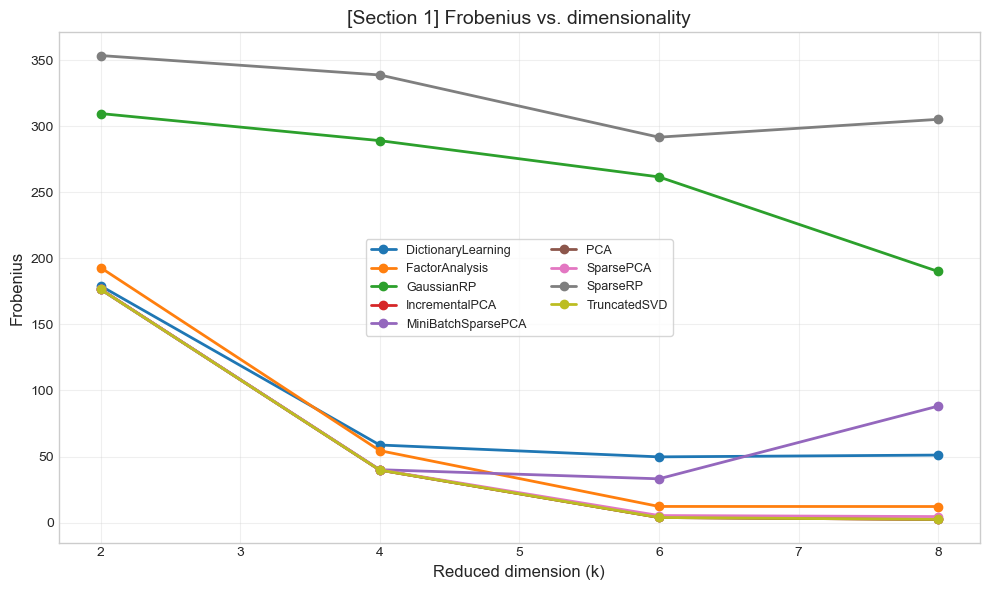

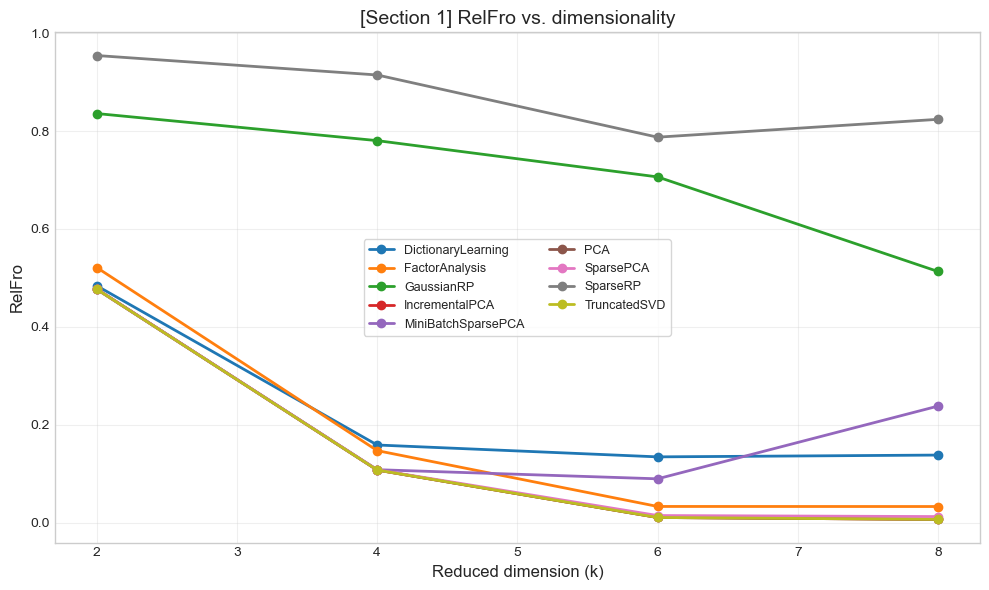

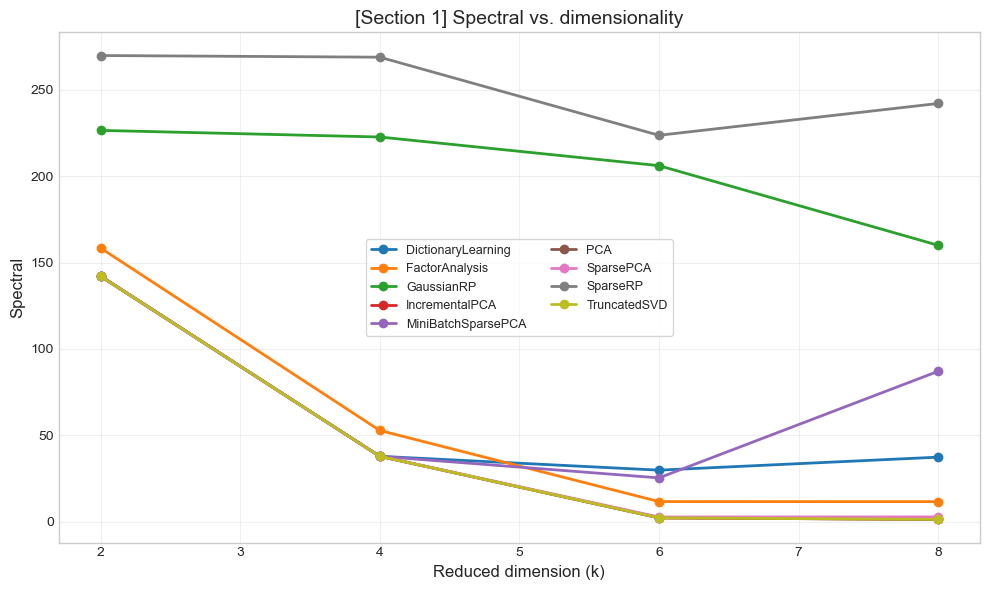

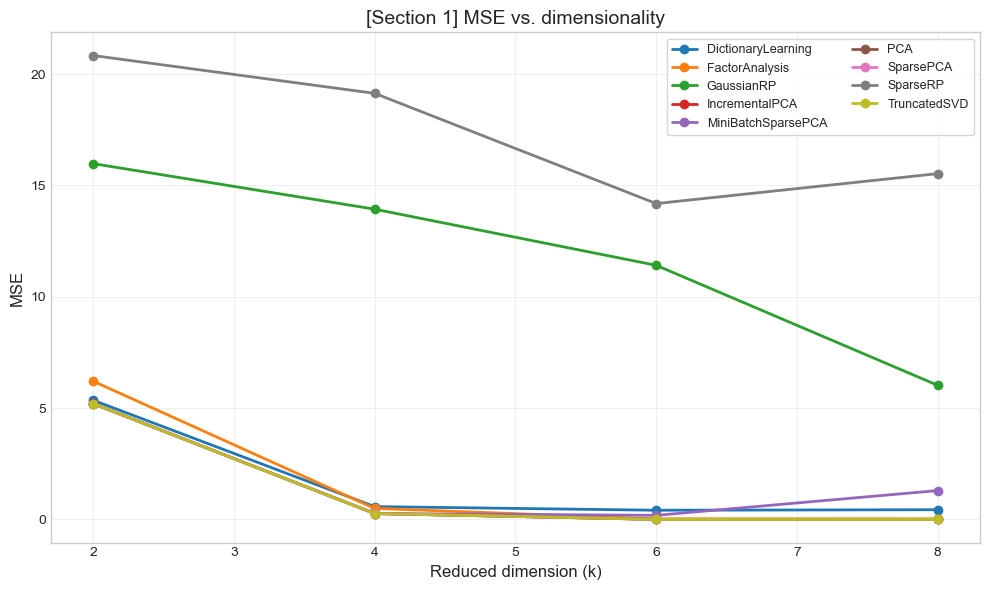

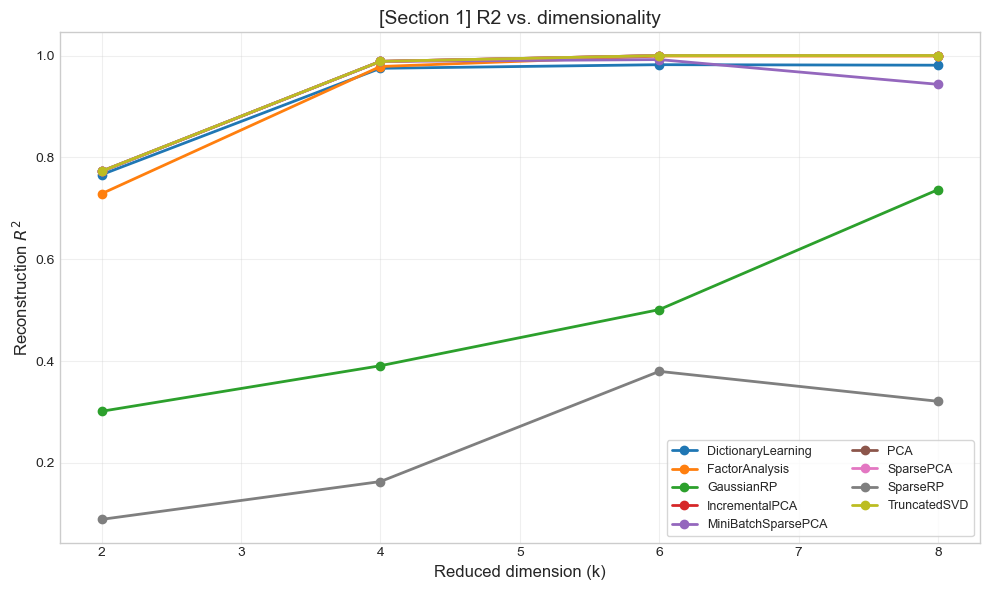


[Section 1] Rankings per dimension (top 5 shown)

  k=2 | Frobenius (lower is better)


,Rank,Method,Frobenius
0,1,PCA,176.567643
1,2,TruncatedSVD,176.567643
2,3,SparsePCA,176.597067
3,4,MiniBatchSparsePCA,176.601393
4,5,IncrementalPCA,176.748435



  k=2 | RelFro (lower is better)


,Rank,Method,RelFro
0,1,PCA,0.476722
1,2,TruncatedSVD,0.476722
2,3,SparsePCA,0.476802
3,4,MiniBatchSparsePCA,0.476813
4,5,IncrementalPCA,0.477210



  k=2 | Spectral (lower is better)


,Rank,Method,Spectral
0,1,PCA,142.039339
1,2,TruncatedSVD,142.039339
2,3,SparsePCA,142.039339
3,4,MiniBatchSparsePCA,142.039830
4,5,DictionaryLearning,142.047396



  k=2 | MSE (lower is better)


,Rank,Method,MSE
0,1,PCA,5.196022
1,2,TruncatedSVD,5.196022
2,3,SparsePCA,5.197754
3,4,MiniBatchSparsePCA,5.198009
4,5,IncrementalPCA,5.206668



  k=2 | R2 (higher is better)


,Rank,Method,R2
0,1,TruncatedSVD,0.772736
1,2,PCA,0.772736
2,3,SparsePCA,0.772660
3,4,MiniBatchSparsePCA,0.772649
4,5,IncrementalPCA,0.772270



  k=4 | Frobenius (lower is better)


,Rank,Method,Frobenius
0,1,PCA,39.743243
1,2,TruncatedSVD,39.743243
2,3,IncrementalPCA,39.744069
3,4,SparsePCA,39.910127
4,5,MiniBatchSparsePCA,40.014960



  k=4 | RelFro (lower is better)


,Rank,Method,RelFro
0,1,PCA,0.107304
1,2,TruncatedSVD,0.107304
2,3,IncrementalPCA,0.107307
3,4,SparsePCA,0.107755
4,5,MiniBatchSparsePCA,0.108038



  k=4 | Spectral (lower is better)


,Rank,Method,Spectral
0,1,PCA,37.812410
1,2,TruncatedSVD,37.812410
2,3,SparsePCA,37.812410
3,4,MiniBatchSparsePCA,37.813133
4,5,IncrementalPCA,37.813277



  k=4 | MSE (lower is better)


,Rank,Method,MSE
0,1,PCA,0.263254
1,2,TruncatedSVD,0.263254
2,3,IncrementalPCA,0.263265
3,4,SparsePCA,0.265470
4,5,MiniBatchSparsePCA,0.266866



  k=4 | R2 (higher is better)


,Rank,Method,R2
0,1,TruncatedSVD,0.988486
1,2,PCA,0.988486
2,3,IncrementalPCA,0.988485
3,4,SparsePCA,0.988389
4,5,MiniBatchSparsePCA,0.988328



  k=6 | Frobenius (lower is better)


,Rank,Method,Frobenius
0,1,PCA,3.841566
1,2,TruncatedSVD,3.841566
2,3,IncrementalPCA,3.841567
3,4,SparsePCA,5.311564
4,5,FactorAnalysis,12.191079



  k=6 | RelFro (lower is better)


,Rank,Method,RelFro
0,1,PCA,0.010372
1,2,TruncatedSVD,0.010372
2,3,IncrementalPCA,0.010372
3,4,SparsePCA,0.014341
4,5,FactorAnalysis,0.032915



  k=6 | Spectral (lower is better)


,Rank,Method,Spectral
0,1,PCA,2.195858
1,2,TruncatedSVD,2.195858
2,3,IncrementalPCA,2.195860
3,4,SparsePCA,2.677109
4,5,FactorAnalysis,11.619323



  k=6 | MSE (lower is better)


,Rank,Method,MSE
0,1,PCA,0.002460
1,2,TruncatedSVD,0.002460
2,3,IncrementalPCA,0.002460
3,4,SparsePCA,0.004702
4,5,FactorAnalysis,0.024770



  k=6 | R2 (higher is better)


,Rank,Method,R2
0,1,TruncatedSVD,0.999892
1,2,PCA,0.999892
2,3,IncrementalPCA,0.999892
3,4,SparsePCA,0.999794
4,5,FactorAnalysis,0.998917



  k=8 | Frobenius (lower is better)


,Rank,Method,Frobenius
0,1,PCA,2.398472
1,2,TruncatedSVD,2.398472
2,3,IncrementalPCA,2.398943
3,4,SparsePCA,4.536730
4,5,FactorAnalysis,12.140858



  k=8 | RelFro (lower is better)


,Rank,Method,RelFro
0,1,PCA,0.006476
1,2,TruncatedSVD,0.006476
2,3,IncrementalPCA,0.006477
3,4,SparsePCA,0.012249
4,5,FactorAnalysis,0.032780



  k=8 | Spectral (lower is better)


,Rank,Method,Spectral
0,1,PCA,1.291535
1,2,TruncatedSVD,1.291535
2,3,IncrementalPCA,1.291537
3,4,SparsePCA,2.739690
4,5,FactorAnalysis,11.564495



  k=8 | MSE (lower is better)


,Rank,Method,MSE
0,1,PCA,0.000959
1,2,TruncatedSVD,0.000959
2,3,IncrementalPCA,0.000959
3,4,SparsePCA,0.003430
4,5,FactorAnalysis,0.024567



  k=8 | R2 (higher is better)


,Rank,Method,R2
0,1,TruncatedSVD,0.999958
1,2,PCA,0.999958
2,3,IncrementalPCA,0.999958
3,4,SparsePCA,0.999850
4,5,FactorAnalysis,0.998925


In [8]:
plot_metric_trends_df(df_linear_scores, title_prefix='[Section 1] ')
rankings_linear = rankings_df(df_linear_scores)

print("\n[Section 1] Rankings per dimension (top 5 shown)")
for d in TARGET_DIMS:
    for m in METRICS:
        df_rank = rankings_linear[d][m]
        print(f"\n  k={d} | {m} {'(higher is better)' if m=='R2' else '(lower is better)'}")
        display(df_rank.head(5))


### Top-3 linear by average R2

In [9]:
avg_R2_lin = avg_metric_by_method(df_linear_scores, metric='R2')
TOP3_LINEAR = list(avg_R2_lin.head(3).items())  # list of (method, score)
print("\n[Section 1] Top-3 linear methods by average R2:")
display(pd.DataFrame(TOP3_LINEAR, columns=['Method','R2_avg']))


[Section 1] Top-3 linear methods by average R2:


,Method,R2_avg
0,TruncatedSVD,0.940268
1,PCA,0.940268
2,SparsePCA,0.940173


## Section 2: Non-linear DR Algorithms on Non-linear Data

In [13]:

# =============================
# Section 2: Non-linear on Non-linear Data
# =============================
Xc_nonlin, mu_nonlin, S_nonlin = generate_nonlinear_data(n_samples=500, n_features=12, true_dim=5)
print(f"[Section 2] Centered non-linear data shape: {Xc_nonlin.shape}")

results_nonlinear = evaluate_methods(Xc_nonlin, NONLINEAR_METHODS, TARGET_DIMS)
df_nonlinear_scores, df_nonlinear_errors = results_to_df(results_nonlinear)

print("\n[Section 2] Scores (DataFrame):")
display(df_nonlinear_scores.sort_values(['Dim','Method']).reset_index(drop=True))

if not df_nonlinear_errors.empty:
    print("\n[Section 2] Errors (DataFrame):")
    display(df_nonlinear_errors)


[Section 2] Centered non-linear data shape: (500, 12)

[Section 2] Scores (DataFrame):


,Method,Dim,Frobenius,RelFro,Spectral,MSE,R2
0,Isomap,2,43.793198,0.183504,24.386454,0.319641,0.966326
1,KernelPCA,2,172.750762,0.723866,166.372375,4.973804,0.476017
2,LLE,2,120.339026,0.504249,111.484699,2.413580,0.745733
3,SpectralEmbedding,2,76.657753,0.321214,58.960609,0.979402,0.896822
4,tSNE,2,129.652072,0.543273,121.905994,2.801610,0.704855
5,Isomap,4,37.625129,0.157658,19.050761,0.235942,0.975144
6,KernelPCA,4,157.843831,0.661403,153.034305,4.152446,0.562546
7,LLE,4,46.388147,0.194377,25.790064,0.358643,0.962217
8,SpectralEmbedding,4,67.291756,0.281968,49.782257,0.754697,0.920494
9,tSNE,4,106.497786,0.446251,99.001971,1.890296,0.800860


### Trends and rankings

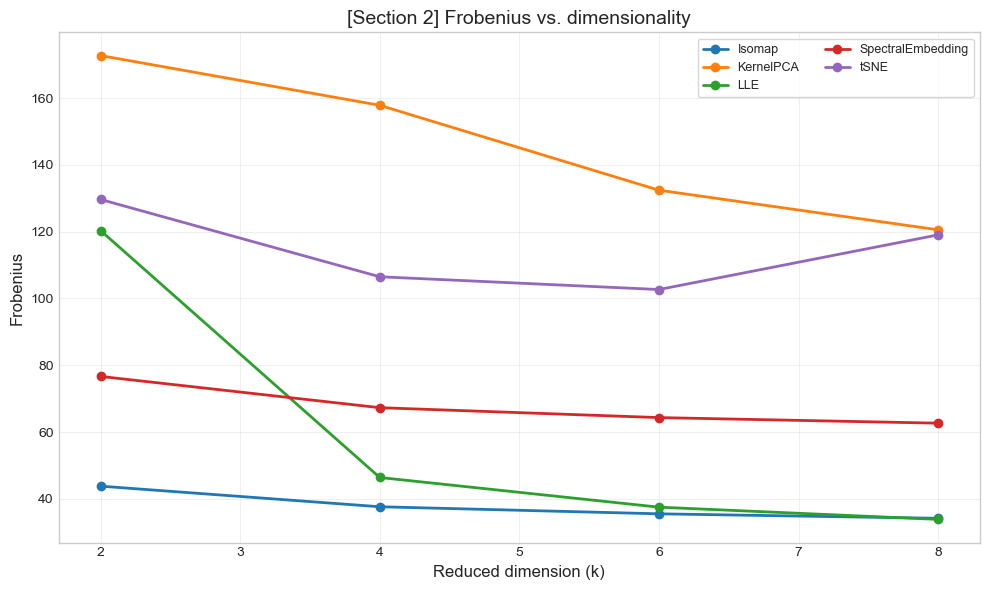

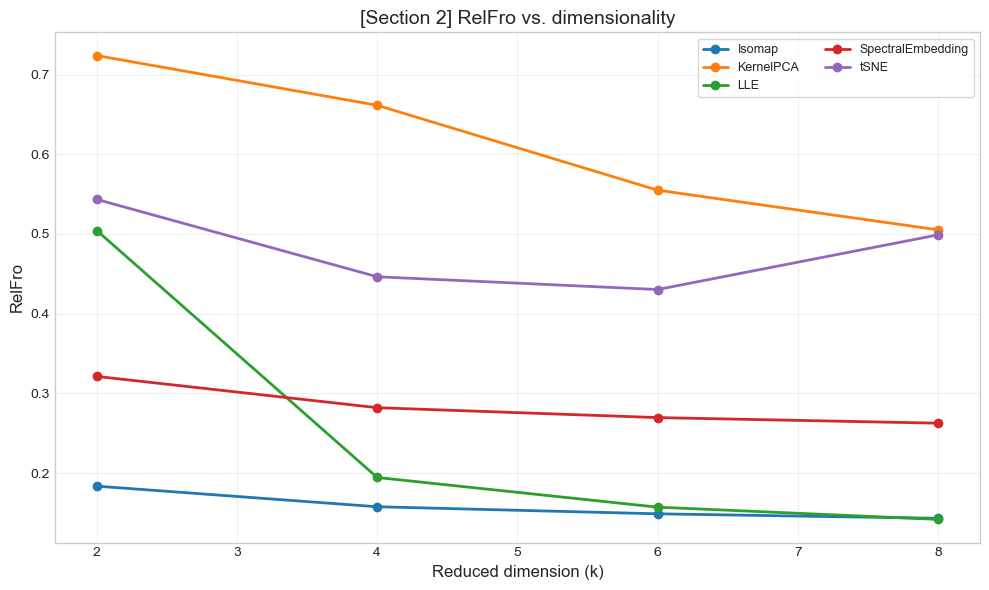

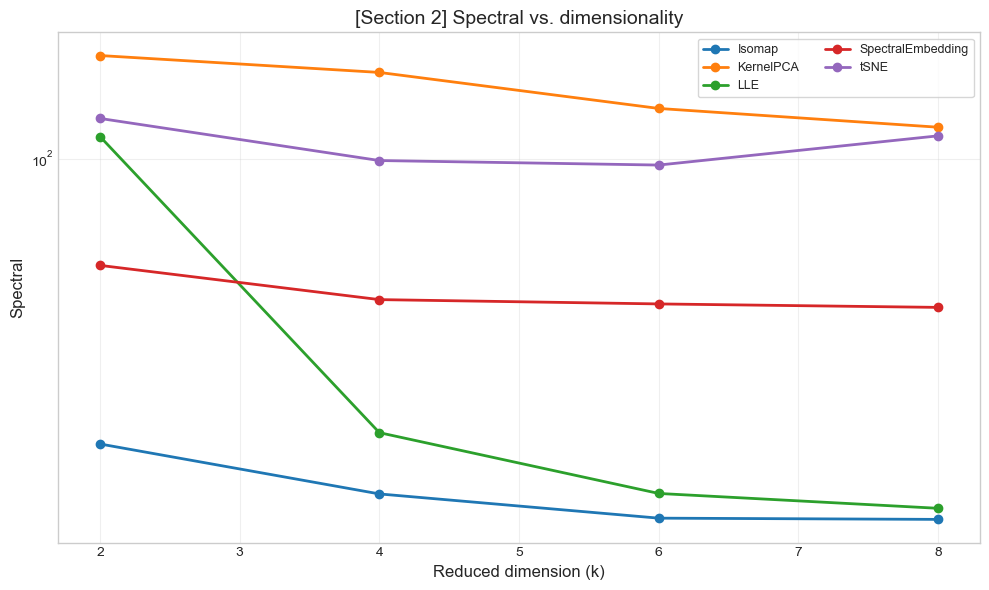

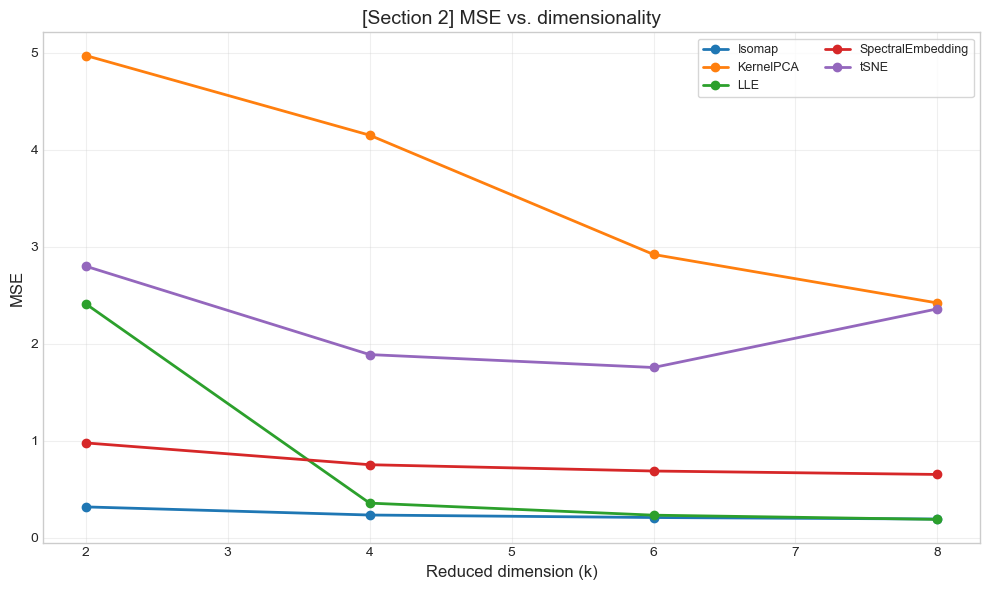

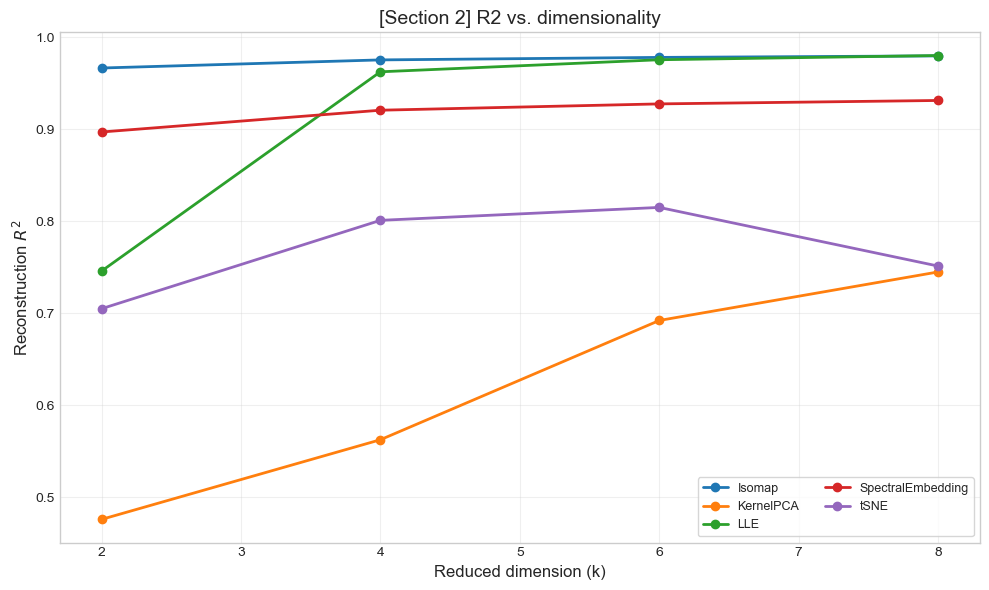


[Section 2] Rankings per dimension (top 5 shown)

  k=2 | Frobenius (lower is better)


,Rank,Method,Frobenius
0,1,Isomap,43.793198
1,2,SpectralEmbedding,76.657753
2,3,LLE,120.339026
3,4,tSNE,129.652072
4,5,KernelPCA,172.750762



  k=2 | RelFro (lower is better)


,Rank,Method,RelFro
0,1,Isomap,0.183504
1,2,SpectralEmbedding,0.321214
2,3,LLE,0.504249
3,4,tSNE,0.543273
4,5,KernelPCA,0.723866



  k=2 | Spectral (lower is better)


,Rank,Method,Spectral
0,1,Isomap,24.386454
1,2,SpectralEmbedding,58.960609
2,3,LLE,111.484699
3,4,tSNE,121.905994
4,5,KernelPCA,166.372375



  k=2 | MSE (lower is better)


,Rank,Method,MSE
0,1,Isomap,0.319641
1,2,SpectralEmbedding,0.979402
2,3,LLE,2.413580
3,4,tSNE,2.801610
4,5,KernelPCA,4.973804



  k=2 | R2 (higher is better)


,Rank,Method,R2
0,1,Isomap,0.966326
1,2,SpectralEmbedding,0.896822
2,3,LLE,0.745733
3,4,tSNE,0.704855
4,5,KernelPCA,0.476017



  k=4 | Frobenius (lower is better)


,Rank,Method,Frobenius
0,1,Isomap,37.625129
1,2,LLE,46.388147
2,3,SpectralEmbedding,67.291756
3,4,tSNE,106.497786
4,5,KernelPCA,157.843831



  k=4 | RelFro (lower is better)


,Rank,Method,RelFro
0,1,Isomap,0.157658
1,2,LLE,0.194377
2,3,SpectralEmbedding,0.281968
3,4,tSNE,0.446251
4,5,KernelPCA,0.661403



  k=4 | Spectral (lower is better)


,Rank,Method,Spectral
0,1,Isomap,19.050761
1,2,LLE,25.790064
2,3,SpectralEmbedding,49.782257
3,4,tSNE,99.001971
4,5,KernelPCA,153.034305



  k=4 | MSE (lower is better)


,Rank,Method,MSE
0,1,Isomap,0.235942
1,2,LLE,0.358643
2,3,SpectralEmbedding,0.754697
3,4,tSNE,1.890296
4,5,KernelPCA,4.152446



  k=4 | R2 (higher is better)


,Rank,Method,R2
0,1,Isomap,0.975144
1,2,LLE,0.962217
2,3,SpectralEmbedding,0.920494
3,4,tSNE,0.800860
4,5,KernelPCA,0.562546



  k=6 | Frobenius (lower is better)


,Rank,Method,Frobenius
0,1,Isomap,35.510889
1,2,LLE,37.501243
2,3,SpectralEmbedding,64.325513
3,4,tSNE,102.675025
4,5,KernelPCA,132.425369



  k=6 | RelFro (lower is better)


,Rank,Method,RelFro
0,1,Isomap,0.148799
1,2,LLE,0.157139
2,3,SpectralEmbedding,0.269539
3,4,tSNE,0.430233
4,5,KernelPCA,0.554894



  k=6 | Spectral (lower is better)


,Rank,Method,Spectral
0,1,Isomap,16.900212
1,2,LLE,19.095370
2,3,SpectralEmbedding,48.732113
3,4,tSNE,96.815992
4,5,KernelPCA,128.075380



  k=6 | MSE (lower is better)


,Rank,Method,MSE
0,1,Isomap,0.210171
1,2,LLE,0.234391
2,3,SpectralEmbedding,0.689629
3,4,tSNE,1.757027
4,5,KernelPCA,2.922746



  k=6 | R2 (higher is better)


,Rank,Method,R2
0,1,Isomap,0.977859
1,2,LLE,0.975307
2,3,SpectralEmbedding,0.927349
3,4,tSNE,0.814900
4,5,KernelPCA,0.692093



  k=8 | Frobenius (lower is better)


,Rank,Method,Frobenius
0,1,LLE,33.840331
1,2,Isomap,34.166791
2,3,SpectralEmbedding,62.653431
3,4,tSNE,119.042423
4,5,KernelPCA,120.556531



  k=8 | RelFro (lower is better)


,Rank,Method,RelFro
0,1,LLE,0.141799
1,2,Isomap,0.143167
2,3,SpectralEmbedding,0.262533
3,4,tSNE,0.498816
4,5,KernelPCA,0.505160



  k=8 | Spectral (lower is better)


,Rank,Method,Spectral
0,1,Isomap,16.797445
1,2,LLE,17.743960
2,3,SpectralEmbedding,47.905118
3,4,tSNE,111.852317
4,5,KernelPCA,116.726368



  k=8 | MSE (lower is better)


,Rank,Method,MSE
0,1,LLE,0.190861
1,2,Isomap,0.194562
2,3,SpectralEmbedding,0.654242
3,4,tSNE,2.361850
4,5,KernelPCA,2.422313



  k=8 | R2 (higher is better)


,Rank,Method,R2
0,1,LLE,0.979893
1,2,Isomap,0.979503
2,3,SpectralEmbedding,0.931077
3,4,tSNE,0.751183
4,5,KernelPCA,0.744813


In [14]:
plot_metric_trends_df(df_nonlinear_scores, title_prefix='[Section 2] ')
rankings_nonlinear = rankings_df(df_nonlinear_scores)

print("\n[Section 2] Rankings per dimension (top 5 shown)")
for d in TARGET_DIMS:
    for m in METRICS:
        df_rank = rankings_nonlinear[d][m]
        print(f"\n  k={d} | {m} {'(higher is better)' if m=='R2' else '(lower is better)'}")
        display(df_rank.head(5))

### Top-3 non-linear by average R2

In [15]:
avg_R2_nonlin = avg_metric_by_method(df_nonlinear_scores, metric='R2')
TOP3_NONLINEAR = list(avg_R2_nonlin.head(3).items())
print("\n[Section 2] Top-3 non-linear methods by average R2:")
display(pd.DataFrame(TOP3_NONLINEAR, columns=['Method','R2_avg']))


[Section 2] Top-3 non-linear methods by average R2:


,Method,R2_avg
0,Isomap,0.974708
1,SpectralEmbedding,0.918935
2,LLE,0.915788


## Section 3: Top performers on Semi-linear Data

[Section 3] Centered semi-linear data shape: (2000, 13)

[Section 3] Scores (DataFrame):


,Method,Dim,Frobenius,RelFro,Spectral,MSE,R2
0,Isomap,2,427.629811,0.602502,339.834459,7.033356,0.636991
1,LLE,2,450.701954,0.635009,338.872037,7.812779,0.596763
2,PCA,2,352.850481,0.497143,274.233135,4.788595,0.752849
3,SparsePCA,2,352.903159,0.497217,274.233135,4.790025,0.752775
4,SpectralEmbedding,2,442.157164,0.622970,329.531008,7.519345,0.611908
5,TruncatedSVD,2,352.850481,0.497143,274.233135,4.788595,0.752849
6,Isomap,4,170.714411,0.240525,108.813649,1.120900,0.942148
7,LLE,4,302.602710,0.426347,255.694444,3.521862,0.818228
8,PCA,4,122.255709,0.172250,105.599468,0.574864,0.970330
9,SparsePCA,4,122.451525,0.172526,105.599468,0.576707,0.970235


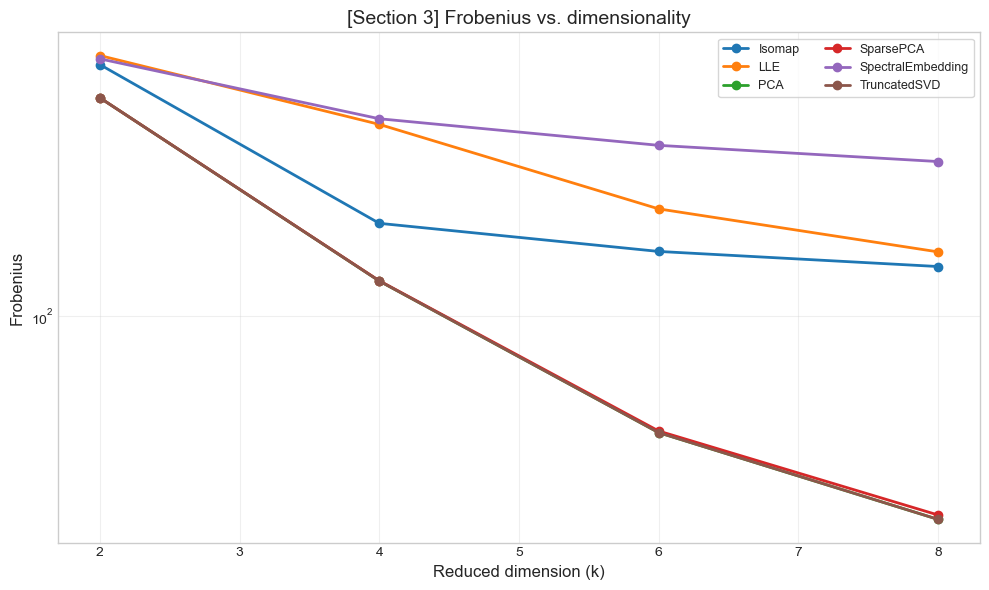

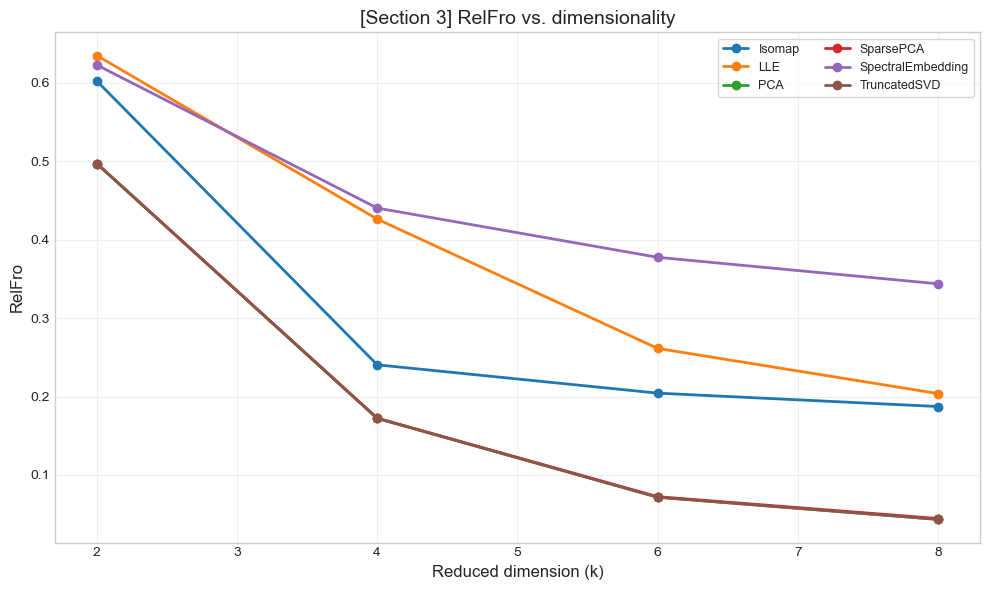

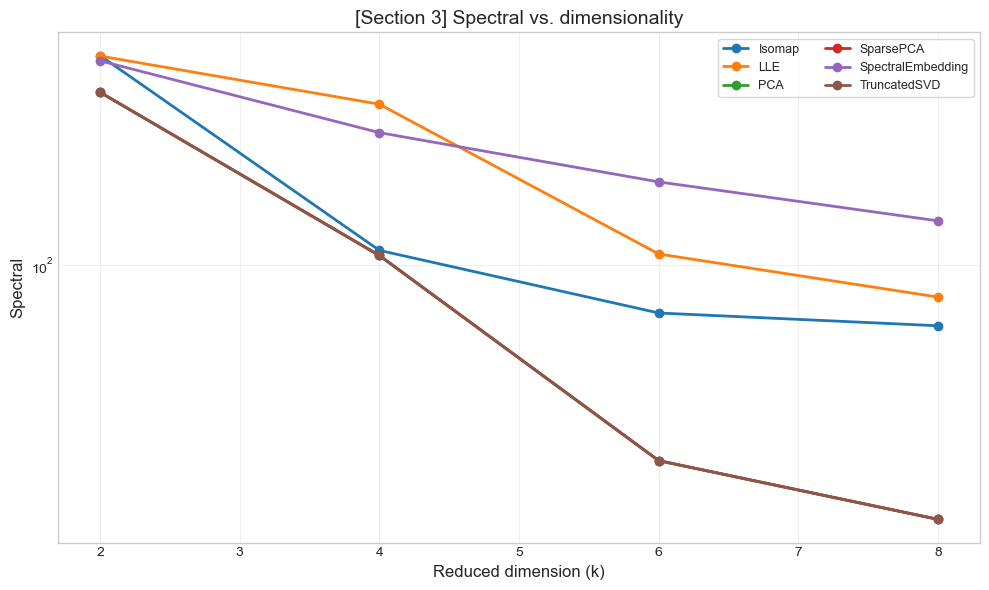

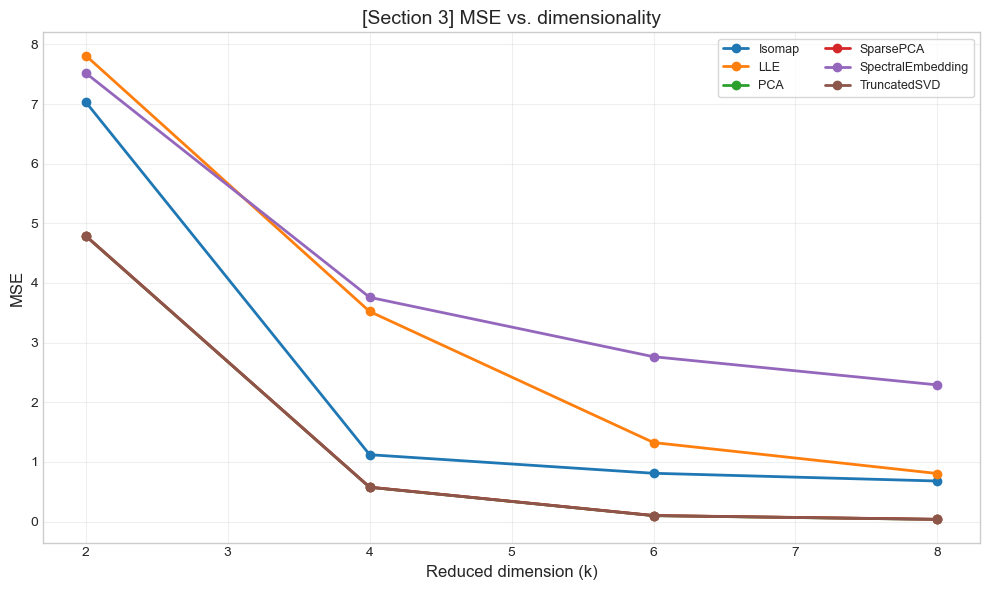

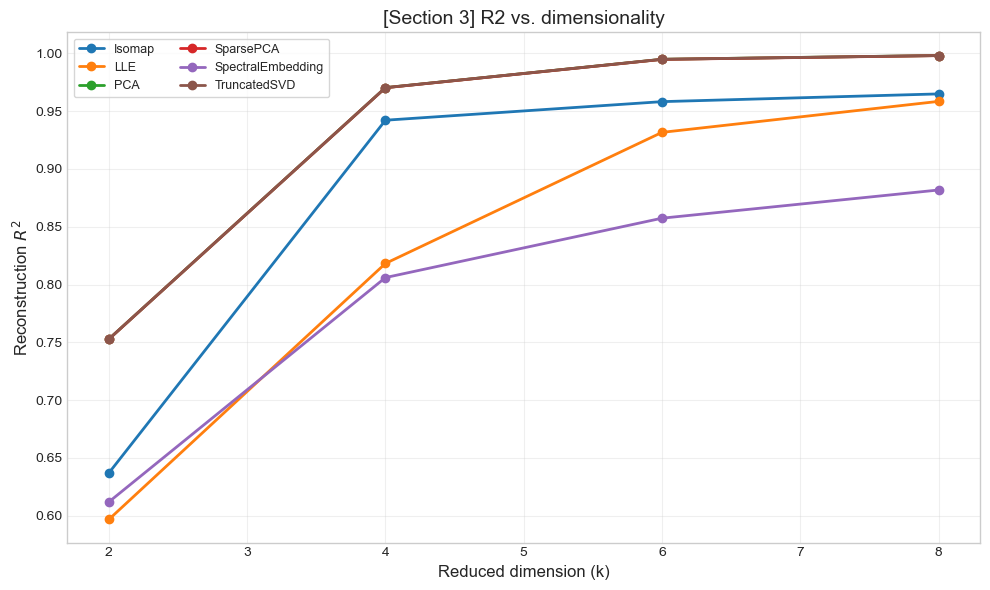


[Section 3] Rankings per dimension (top 5 shown)

  k=2 | Frobenius (lower is better)


,Rank,Method,Frobenius
0,1,PCA,352.850481
1,2,TruncatedSVD,352.850481
2,3,SparsePCA,352.903159
3,4,Isomap,427.629811
4,5,SpectralEmbedding,442.157164



  k=2 | RelFro (lower is better)


,Rank,Method,RelFro
0,1,PCA,0.497143
1,2,TruncatedSVD,0.497143
2,3,SparsePCA,0.497217
3,4,Isomap,0.602502
4,5,SpectralEmbedding,0.622970



  k=2 | Spectral (lower is better)


,Rank,Method,Spectral
0,1,PCA,274.233135
1,2,TruncatedSVD,274.233135
2,3,SparsePCA,274.233135
3,4,SpectralEmbedding,329.531008
4,5,LLE,338.872037



  k=2 | MSE (lower is better)


,Rank,Method,MSE
0,1,PCA,4.788595
1,2,TruncatedSVD,4.788595
2,3,SparsePCA,4.790025
3,4,Isomap,7.033356
4,5,SpectralEmbedding,7.519345



  k=2 | R2 (higher is better)


,Rank,Method,R2
0,1,TruncatedSVD,0.752849
1,2,PCA,0.752849
2,3,SparsePCA,0.752775
3,4,Isomap,0.636991
4,5,SpectralEmbedding,0.611908



  k=4 | Frobenius (lower is better)


,Rank,Method,Frobenius
0,1,TruncatedSVD,122.255709
1,2,PCA,122.255709
2,3,SparsePCA,122.451525
3,4,Isomap,170.714411
4,5,LLE,302.602710



  k=4 | RelFro (lower is better)


,Rank,Method,RelFro
0,1,TruncatedSVD,0.172250
1,2,PCA,0.172250
2,3,SparsePCA,0.172526
3,4,Isomap,0.240525
4,5,LLE,0.426347



  k=4 | Spectral (lower is better)


,Rank,Method,Spectral
0,1,PCA,105.599468
1,2,TruncatedSVD,105.599468
2,3,SparsePCA,105.599468
3,4,Isomap,108.813649
4,5,SpectralEmbedding,216.525963



  k=4 | MSE (lower is better)


,Rank,Method,MSE
0,1,TruncatedSVD,0.574864
1,2,PCA,0.574864
2,3,SparsePCA,0.576707
3,4,Isomap,1.120900
4,5,LLE,3.521862



  k=4 | R2 (higher is better)


,Rank,Method,R2
0,1,TruncatedSVD,0.970330
1,2,PCA,0.970330
2,3,SparsePCA,0.970235
3,4,Isomap,0.942148
4,5,LLE,0.818228



  k=6 | Frobenius (lower is better)


,Rank,Method,Frobenius
0,1,PCA,50.852675
1,2,TruncatedSVD,50.852675
2,3,SparsePCA,51.333530
3,4,Isomap,145.084090
4,5,LLE,185.583242



  k=6 | RelFro (lower is better)


,Rank,Method,RelFro
0,1,PCA,0.071648
1,2,TruncatedSVD,0.071648
2,3,SparsePCA,0.072326
3,4,Isomap,0.204414
4,5,LLE,0.261475



  k=6 | Spectral (lower is better)


,Rank,Method,Spectral
0,1,PCA,31.830299
1,2,TruncatedSVD,31.830299
2,3,SparsePCA,31.830299
3,4,Isomap,75.456513
4,5,LLE,106.525622



  k=6 | MSE (lower is better)


,Rank,Method,MSE
0,1,TruncatedSVD,0.099461
1,2,PCA,0.099461
2,3,SparsePCA,0.101351
3,4,Isomap,0.809592
4,5,LLE,1.324659



  k=6 | R2 (higher is better)


,Rank,Method,R2
0,1,TruncatedSVD,0.994867
1,2,PCA,0.994867
2,3,SparsePCA,0.994769
3,4,Isomap,0.958215
4,5,LLE,0.931631



  k=8 | Frobenius (lower is better)


,Rank,Method,Frobenius
0,1,PCA,30.785413
1,2,TruncatedSVD,30.785413
2,3,SparsePCA,31.576182
3,4,Isomap,132.957700
4,5,LLE,144.711487



  k=8 | RelFro (lower is better)


,Rank,Method,RelFro
0,1,PCA,0.043375
1,2,TruncatedSVD,0.043375
2,3,SparsePCA,0.044489
3,4,Isomap,0.187329
4,5,LLE,0.203889



  k=8 | Spectral (lower is better)


,Rank,Method,Spectral
0,1,PCA,22.581782
1,2,TruncatedSVD,22.581782
2,3,SparsePCA,22.581782
3,4,Isomap,70.026197
4,5,LLE,82.811529



  k=8 | MSE (lower is better)


,Rank,Method,MSE
0,1,PCA,0.036452
1,2,TruncatedSVD,0.036452
2,3,SparsePCA,0.038348
3,4,Isomap,0.679913
4,5,LLE,0.805439



  k=8 | R2 (higher is better)


,Rank,Method,R2
0,1,TruncatedSVD,0.998119
1,2,PCA,0.998119
2,3,SparsePCA,0.998021
3,4,Isomap,0.964908
4,5,LLE,0.958429


In [16]:

Xc_semilin, mu_semilin, S_semilin = generate_semilinear_data(n_samples=2000, n_features=12, true_dim=5)
print(f"[Section 3] Centered semi-linear data shape: {Xc_semilin.shape}")

# Build combined dict of top-3 linear + top-3 non-linear
LINEAR_METHODS_MAP = {name: LINEAR_METHODS[name] for name, _ in TOP3_LINEAR}
NONLINEAR_METHODS_MAP = {name: NONLINEAR_METHODS[name] for name, _ in TOP3_NONLINEAR}
COMBINED_TOP6 = {}
COMBINED_TOP6.update(LINEAR_METHODS_MAP)
COMBINED_TOP6.update(NONLINEAR_METHODS_MAP)

results_semilinear = evaluate_methods(Xc_semilin, COMBINED_TOP6, TARGET_DIMS)
df_semilinear_scores, df_semilinear_errors = results_to_df(results_semilinear)

print("\n[Section 3] Scores (DataFrame):")
display(df_semilinear_scores.sort_values(['Dim','Method']).reset_index(drop=True))

if not df_semilinear_errors.empty:
    print("\n[Section 3] Errors (DataFrame):")
    display(df_semilinear_errors)

plot_metric_trends_df(df_semilinear_scores, title_prefix='[Section 3] ')
rankings_semilinear = rankings_df(df_semilinear_scores)

print("\n[Section 3] Rankings per dimension (top 5 shown)")
for d in TARGET_DIMS:
    for m in METRICS:
        df_rank = rankings_semilinear[d][m]
        print(f"\n  k={d} | {m} {'(higher is better)' if m=='R2' else '(lower is better)'}")
        display(df_rank.head(5))


## Summary Dashboard

### Average metrics per method (by section)

In [17]:

summary_linear = df_linear_scores.groupby('Method')[METRICS].mean().sort_values('R2', ascending=False)
summary_nonlinear = df_nonlinear_scores.groupby('Method')[METRICS].mean().sort_values('R2', ascending=False)
summary_semilinear = df_semilinear_scores.groupby('Method')[METRICS].mean().sort_values('R2', ascending=False)

print("[Dashboard] Average metrics per method — Linear section")
display(summary_linear)
print("\n[Dashboard] Average metrics per method — Non-linear section")
display(summary_nonlinear)
print("\n[Dashboard] Average metrics per method — Semi-linear section (Top-6 only)")
display(summary_semilinear)

[Dashboard] Average metrics per method — Linear section


,Frobenius,RelFro,Spectral,MSE,R2
Method,,,,,
TruncatedSVD,55.637731,0.150219,45.834785,1.365674,0.940268
PCA,55.637731,0.150219,45.834785,1.365674,0.940268
SparsePCA,56.588872,0.152787,46.317137,1.367839,0.940173
IncrementalPCA,55.683253,0.150342,45.886126,1.368338,0.940151
FactorAnalysis,67.943785,0.183444,58.595872,1.687806,0.926179
DictionaryLearning,84.681195,0.228634,61.752837,1.693424,0.925933
MiniBatchSparsePCA,84.468061,0.228059,73.053386,1.735632,0.924087
GaussianRP,262.602252,0.709011,203.849192,11.833967,0.482405
SparseRP,322.316408,0.870236,251.166557,17.417742,0.238181



[Dashboard] Average metrics per method — Non-linear section


,Frobenius,RelFro,Spectral,MSE,R2
Method,,,,,
Isomap,37.774002,0.158282,19.283718,0.240079,0.974708
SpectralEmbedding,67.732113,0.283814,51.345024,0.769492,0.918935
LLE,59.517187,0.249391,43.528523,0.799369,0.915788
tSNE,114.466827,0.479643,107.394069,2.202696,0.767949
KernelPCA,145.894123,0.611331,141.052107,3.617827,0.618867



[Dashboard] Average metrics per method — Semi-linear section (Top-6 only)


,Frobenius,RelFro,Spectral,MSE,R2
Method,,,,,
TruncatedSVD,139.186070,0.196104,108.561171,1.374843,0.929041
PCA,139.186070,0.196104,108.561171,1.374843,0.929041
SparsePCA,139.566099,0.196639,108.561171,1.376608,0.928950
Isomap,219.096503,0.308693,148.532704,2.410940,0.875565
LLE,270.899848,0.381680,195.975908,3.366185,0.826263
SpectralEmbedding,316.721663,0.446240,209.425347,4.083179,0.789257


### Consolidated Top performers table

In [18]:

top3_lin_df = pd.DataFrame(TOP3_LINEAR, columns=['Method','R2_avg']).assign(Section='Linear')
top3_nonlin_df = pd.DataFrame(TOP3_NONLINEAR, columns=['Method','R2_avg']).assign(Section='Non-linear')
consolidated_top = pd.concat([top3_lin_df, top3_nonlin_df], ignore_index=True)
consolidated_top = consolidated_top.sort_values(['Section','R2_avg'], ascending=[True, False])
print("\n[Dashboard] Consolidated Top-3 (Linear & Non-linear)")
display(consolidated_top)


[Dashboard] Consolidated Top-3 (Linear & Non-linear)


,Method,R2_avg,Section
0,TruncatedSVD,0.940268,Linear
1,PCA,0.940268,Linear
2,SparsePCA,0.940173,Linear
3,Isomap,0.974708,Non-linear
4,SpectralEmbedding,0.918935,Non-linear
5,LLE,0.915788,Non-linear


### Bar chart comparison of R2_avg for top-3 of each section

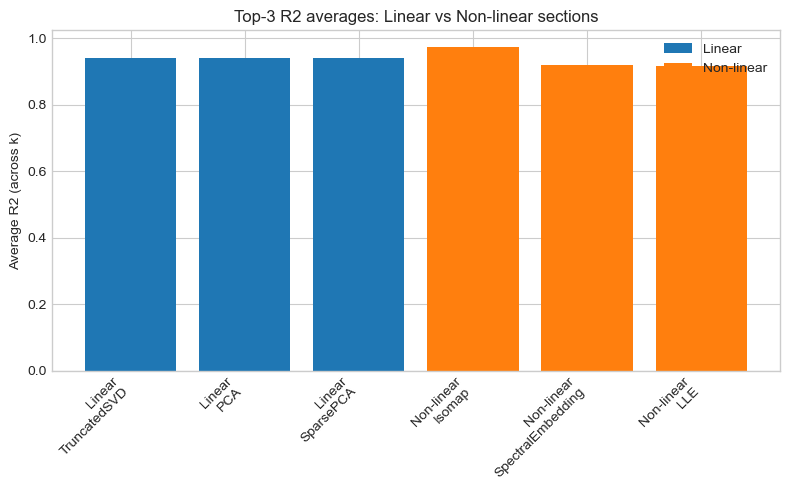

In [19]:

plt.figure(figsize=(8,5))
for i, (sect_name, sect_df) in enumerate([("Linear", top3_lin_df), ("Non-linear", top3_nonlin_df)]):
    plt.bar([f"{sect_name}\n{m}" for m in sect_df['Method']], sect_df['R2_avg'], label=sect_name)
plt.ylabel('Average R2 (across k)')
plt.title('Top-3 R2 averages: Linear vs Non-linear sections')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


### Heatmap-like table: methods vs dims for R2 (semi-linear top-6)

In [20]:

pivot_semilin = df_semilinear_scores.pivot_table(index='Method', columns='Dim', values='R2', aggfunc='mean')
print("\n[Dashboard] Semi-linear R2 by method and dimension (Top-6)")
display(pivot_semilin)



[Dashboard] Semi-linear R2 by method and dimension (Top-6)


Dim,2,4,6,8
Method,,,,
Isomap,0.636991,0.942148,0.958215,0.964908
LLE,0.596763,0.818228,0.931631,0.958429
PCA,0.752849,0.970330,0.994867,0.998119
SparsePCA,0.752775,0.970235,0.994769,0.998021
SpectralEmbedding,0.611908,0.805988,0.857372,0.881761
TruncatedSVD,0.752849,0.970330,0.994867,0.998119



## Notes
- Tables are presented as **pandas DataFrames** for clarity and downstream export.
- Trend plots and rankings are computed from the DataFrames.
- t‑SNE uses **Barnes–Hut** for k ≤ 3 and **Exact** for k ≥ 4 to satisfy algorithmic constraints.
- Reconstruction for methods without `inverse_transform` uses the **least‑squares decoder** from embedding to data space.
- Metrics are simple matrix/vector quantities (norms, MSE, R²) on **centered** data.
